# Weighted Ensemble

In this notebook we will see how easy it is to implement the weighted ensemble method using `asyncmd`. The implementation below is limited to bins along one CV but supports unequal binsizes. It can also be used with any `asyncmd` engine and `TrajectoryFunctionWrapper` (this means you could run this on a cluster simply by using slurm enabled versions of the engine and ensemble CV). We will test/showcase our implementation using the local gromacs engine on the example of capped alanine dipeptide (as always), but it is easy to use a different molecular system and ensemble CV.

For an introduction to the weighted ensemble method see e.g. "The “weighted ensemble” path sampling method is statistically exact for a broad class of stochastic processes and binning procedures" by Zhang, Jasnow and Zuckerman (2010, J. Chem. Phys.; https://aip.scitation.org/doi/10.1063/1.3306345).

**This notebook should be run on a multi-core workstation preferably with a GPU**, otherwise you will have a very long coffee break and a very hot laptop.

**Required knowledge/recommended reading**: This notebook assumes some familarity with the gromacs engine (see the notebooks in the `01_engines/gromacs` directory) and the TrajectoryFunctionWrappers (see notebooks `PyTrajectoryFunctionWrapper.ipynb` and/or `SlurmTrajectoryFunctionWrapper.ipynb`).

In [1]:
%matplotlib inline

In [2]:
#%%bash
#module list

In [3]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import MDAnalysis as mda
import asyncio
import asyncmd
import asyncmd.gromacs as asyncgmx
import asyncmd.trajectory as asynctraj

/home/tb/hejung/.conda/envs/asyncmd_dev/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Could not initialize SLURM cluster handling. If you are sure SLURM (sinfo/sacct/etc) is available try calling `asyncmd.config.set_slurm_settings()` with the appropriate arguments.


In [4]:
# define the working directory for tajectory generation/etc
working_directory = "weighted_ensemble"

## Define weighted ensemble simulation classes
We define one userfacing weighted ensemble class that keeps track of the history and takes care of splitting/pruning of the single simulations and which handles most of the bookkeeping. The actual molecular dynamics simulations are handled by the lightweight walker class which just propagates the trajectories on request and keeps track of its own history of trajectories and associated weights.

The full implementation including (extensive) comments is just 220 lines of code, I recomend having a quick read over it. In any case this shows how easy it is to implement more complex dynamic path based sampling schemes using `asyncmd`. While the implementation is fairly general (i.e. you can easily use it with different molecular systems and ensemble CVs) and can be run on a cluster, please have a list at the points below **before** using it in a production setting.

If you implement any of the points below (or anything else that is useful) please feel free to submit a pull request to let everybody profit from your hard work. :)

#### What is missing for a "good" implementation:
- Better/more history/logging and make the history and sampler class saveable for analysis and restarts. One can (probably) just pickle the sampler object, but it would also be good to keep track of the history of trajectories in the filesystem. For this one would probably need to write out the weights for each trajectory part next to the trajectories and symlink the parent walkers folder when splitting a walker. Also maybe write to the filesystem after which round a walker was pruned.
- Currently the implementation assumes gromacs engines, because we hardcode xtc/trr trajectory output and write the starting configuration for new trajectories as trr. This means that in the current state this will only work with `GmxEngine` and `SlurmGmxEngine` engine classes. While it is easy to adopt it to any other engine by changing the hardcoded formats to some other format it would be nice to have a general solution working for all engines (to output low precision/compressed trajectories except for the last and first frames).
- 2d/Nd generalization
- ...

In [5]:
class EnsembleWalker:
    traj_deffnm = "WE_walker"
    
    def __init__(self, workdir, engine_cls, engine_kwargs, starting_configuration, nsteps_per_part, current_weight, walker_id, parent_walker=None):
        self.workdir = workdir
        self.engine_cls = engine_cls
        self.engine_kwargs = engine_kwargs
        self.starting_configuration = starting_configuration
        self.nsteps_per_part = nsteps_per_part
        self.current_weight = current_weight
        self.walker_id = walker_id
        if parent_walker is not None:
            self.parent_walker_id = parent_walker.walker_id
            self.current_traj = parent_walker.current_traj
        else:
            self.current_traj = None

        self._initialized = False
        self._engine = None
        self.trajectories = [] # list of tuples: (traj, weight)
        
    async def _prepare(self):
        self._engine = self.engine_cls(**self.engine_kwargs)
        await self._engine.prepare(starting_configuration=self.starting_configuration,
                                   workdir=self.workdir,
                                   deffnm=self.traj_deffnm)
    
    async def make_traj(self):
        if not self._initialized:
            await self._prepare()
            self._initialized = True
        return_traj = await self._engine.run_steps(nsteps=self.nsteps_per_part, steps_per_part=True)
        self.current_traj = return_traj
        self.trajectories += [(return_traj, self.current_weight)]
        return return_traj, self.current_weight


class WeightedEnsemble_1d:
    #rounddir_prefix = "round_"
    walkerdir_prefix = "walker_"
    
    def __init__(self, workdir, engine_cls, engine_kwargs, ensemble_cv, bin_edges, nsteps_per_round, n_traj_target, verbose=False):
        self.workdir = workdir
        self.engine_cls = engine_cls
        self.engine_kwargs = engine_kwargs
        self.ensemble_cv = ensemble_cv
        self.bin_edges = np.array(bin_edges)
        self.nsteps_per_round = nsteps_per_round
        self.n_traj_target = n_traj_target
        self.verbose = verbose

        self._rng = np.random.default_rng()
        self.walkers = {} # dict of all walkers that ever lived, keys are the ids (as int!)
        self.active_walker_ids = [] # list of all active walker ids
        self._walker_id_count = 0  # this is just a continously increased ID, not the index of the walker (we use it to have unique dirnames)
        self._walker_ids_by_bins = [[] for _ in range(self.n_bins)]
        self.history = [] # we will have a list of dicts for each round in here
                          # with dict keys: "traj", "weight", "walker_id",

    @property
    def n_bins(self):
        return len(self.bin_edges) - 1

    async def get_bin_idxs_for_traj(self, traj):
        cv_vals = await self.ensemble_cv(traj)
        bin_idxs = np.digitize(cv_vals, self.bin_edges) - 1
        return bin_idxs

    async def _sort_walkers_into_bins(self):
        self._walker_ids_by_bins = [[] for _ in range(self.n_bins)]
        bin_idxs_by_walker = await asyncio.gather(*(self.get_bin_idxs_for_traj(self.walkers[w_id].current_traj)
                                                    for w_id in self.active_walker_ids))
        for walker_id, current_bin_idxs in zip(self.active_walker_ids, bin_idxs_by_walker):
            self._walker_ids_by_bins[current_bin_idxs[-1]] += [walker_id]

    def _create_walker(self, starting_configuration, starting_weight, walker_dir, walker_id, parent_walker):
        # Note: we expect walkerdir to exist already (this way we can write starting_configuration to that dir already)
        #walker_wdir = os.path.join(workdir, f"{self.walkerdir_prefix}{self._walker_count}")
        self.walkers[walker_id] = EnsembleWalker(workdir=walker_dir,
                                                  engine_cls=self.engine_cls,
                                                  engine_kwargs=self.engine_kwargs,
                                                  starting_configuration=starting_configuration,
                                                  nsteps_per_part=self.nsteps_per_round,
                                                  current_weight=starting_weight,
                                                  walker_id=walker_id,
                                                  parent_walker=parent_walker,
                                                  )
        self.active_walker_ids += [walker_id]

    async def _split_walker(self, walker_id, new_walker_ids):
        # this splits the walker with walker_id as many times as we get new_walker_ids,
        # reduce the weight of the old walker
        self.walkers[walker_id].current_weight /= len(new_walker_ids) + 1  # we have n_new + 1 old replica of the walker
        # keep track of the parent walker (id)
        parent_walker = self.walkers[walker_id]
        for new_walker_id in new_walker_ids:
            walker_dir = os.path.join(self.workdir, f"{self.walkerdir_prefix}{new_walker_id}")
            os.mkdir(walker_dir)
            frame_extractor = asynctraj.convert.NoModificationFrameExtractor()
            # make sure we use the full precision trr trajectory for restart even if the engine output traj is xtc
            # Note: this of course only works if gromacs writes both trajectories, i.e. we have to make sure that
            #       the number of total steps per round is divisible by nstxout and nstvout when setting up the mdp options
            if parent_walker.current_traj.trajectory_files[0].lower().endswith(".trr"):
                traj_in = parent_walker.current_traj
            elif parent_walker.current_traj.trajectory_files[0].lower().endswith(".xtc"):
                traj_in = asyncmd.Trajectory(trajectory_files=parent_walker.current_traj.trajectory_files[0][:-3] + "trr",
                                             structure_file=parent_walker.current_traj.structure_file,
                                             )
            starting_configuration = frame_extractor.extract(outfile=os.path.join(walker_dir, "initial_configuration.trr"),
                                                             traj_in=traj_in,
                                                             idx=-1,
                                                             )
            # create the new walker with the new weight
            self._create_walker(starting_configuration=starting_configuration,
                                starting_weight=parent_walker.current_weight,
                                walker_dir=walker_dir,
                                walker_id=new_walker_id,
                                parent_walker=parent_walker,
                                )
    
    async def _split_bin(self, bin_idx):
        # splits walkers in given bin (if needed)
        # returns the walker_ids of the created walkers
        walker_ids = np.array(self._walker_ids_by_bins[bin_idx])
        n_walkers_to_create = self.n_traj_target - len(walker_ids)
        if len(walker_ids) > 0 and n_walkers_to_create > 0:
            # need to have at least one (but less than n_traj_target) walker in the bin to (need and be able to) split
            weights = np.array([self.walkers[w_id].current_weight for w_id in walker_ids])
            probs = weights / np.sum(weights)
            walker_to_split_id = self._rng.choice(walker_ids, p=probs)
            # get the new walker_ids and update our id counter
            new_walker_ids = [w_id for w_id in range(self._walker_id_count, self._walker_id_count + n_walkers_to_create)]
            self._walker_id_count += n_walkers_to_create
            if self.verbose > 1:
                print(f"Created {len(new_walker_ids)} new walkers (with ids {new_walker_ids}) by "
                      + f"splitting walker with id {walker_to_split_id} in bin [{self.bin_edges[bin_idx]}, {self.bin_edges[bin_idx + 1]}]."
                      )
            await self._split_walker(walker_id=walker_to_split_id,
                                     new_walker_ids=new_walker_ids,
                                     )
            return new_walker_ids
        else:
            return []

    async def _prune_bin(self, bin_idx):
        # prunes a given bin (if needed)
        # returns a list with the walker ids of the walkers that got pruned
        walker_ids = np.array(self._walker_ids_by_bins[bin_idx])
        n_walkers_to_create = self.n_traj_target - len(walker_ids)
        if n_walkers_to_create < 0:
            # pruning/merging time!
            # Note: n_walkers_to_create is negative!
            weights = np.array([self.walkers[w_id].current_weight for w_id in walker_ids])
            sort_idxs = np.argsort(weights)
            sorted_weights = weights[sort_idxs]
            sorted_weights = sorted_weights[:(-n_walkers_to_create + 1)]  # keep only the weights of walkers we consider for pruning
            weight_sum = np.sum(sorted_weights)
            sorted_probs = sorted_weights / weight_sum
            sorted_walker_ids = walker_ids[sort_idxs]
            # we prune the -n_walkers_to_create walkers with the lowest weights
            # and draw at random which walkers history to keep
            walker_ids_to_potentialy_prune = sorted_walker_ids[:(-n_walkers_to_create + 1)]
            walker_id_to_merge_with = self._rng.choice(walker_ids_to_potentialy_prune, p=sorted_probs)
            # create a list of walker ids for the walkers we chose to prune
            walker_ids_to_prune = list(walker_ids_to_potentialy_prune)
            walker_ids_to_prune.remove(walker_id_to_merge_with)
            # update the weight of the surviving walker
            self.walkers[walker_id_to_merge_with].current_weight = weight_sum
            # and set the weights of the pruned walkers to zero
            for prune_w_id in walker_ids_to_prune:
                self.walkers[prune_w_id].current_weight = 0
            if self.verbose > 1:
                print(f"Pruned {-n_walkers_to_create} walkers from ids {walker_ids_to_prune} by merging it with walker id {walker_id_to_merge_with}"
                      + f" in bin [{self.bin_edges[bin_idx]}, {self.bin_edges[bin_idx + 1]}].")
            return walker_ids_to_prune
        else:
            return []

    async def split_and_prune_all_bins(self):
        await self._sort_walkers_into_bins()  # make sure our walker to bin mapping is up to date
        # first split (where needed)
        created_walkers = await asyncio.gather(*(self._split_bin(bin_idx) for bin_idx in range(self.n_bins)))
        # and prune (where needed)
        pruned_walkers = await asyncio.gather(*(self._prune_bin(bin_idx) for bin_idx in range(self.n_bins)))
        # remove the pruned walkers from active walker id list
        for to_prune_ids in pruned_walkers:
            for w_id in to_prune_ids:
                self.active_walker_ids.remove(w_id)
        if self.verbose:
            n_created = sum(len(created_per_bin) for created_per_bin in created_walkers)
            n_pruned = sum(len(pruned_per_bin) for pruned_per_bin in pruned_walkers)
            print(f"Created a total of {n_created} and pruned a total of {n_pruned} walkers.")

    async def run_one_round(self):
        # run all walkers for one round and then check for split and prune possibilities
        results = await asyncio.gather(*(self.walkers[w_id].make_traj() for w_id in self.active_walker_ids))
        result_dict_list = []
        for walker_id, (traj, weight) in enumerate(results):
            result_dict_list += [{"traj": traj, "weight": weight,
                                  "walker_id": walker_id,
                                  }]
        self.history += [result_dict_list]
        # merge and split as apropriate
        await self.split_and_prune_all_bins()

    async def run_n_rounds(self, n_rounds):
        # run all walkers for n_rounds
        for _ in range(n_rounds):
            await self.run_one_round()

    def create_walker(self, starting_configuration, weight=1):
        new_walker_id = self._walker_id_count
        self._walker_id_count += 1
        walker_dir = os.path.join(self.workdir, f"{self.walkerdir_prefix}{new_walker_id}")
        os.makedirs(walker_dir)
        # create the new walker with the new weight
        self._create_walker(starting_configuration=starting_configuration,
                            starting_weight=weight,
                            walker_dir=walker_dir,
                            walker_id=new_walker_id,
                            parent_walker=None,  # this walker has no parent
                            )


## Setup and run weighted ensemble simulation of capped alanine dipeptide

We will setup $\psi$ as our ensemble CV with smallish bins from zero to pi and one large bin from -pi to 0. This way we will preferentially sample the transition between $\alpha_R$ (corresponding to an $\alpha$-helical backbone) and $C7_{eq}$ (corresponding to a $\beta$-sheet like backbone) over the low barrier. Note that focussing the sampling on the region $\psi > 0$ also increases the transition probability to the $\alpha_L$ and $C7_{ax}$ states (both with $\phi > 0$), because they are most accessible from the $C7_{eq}$ state and/or the transition over the low barrier.

You can however easily change the ensemble CV to $\phi$ to explicitly enhance the sampling of the transition to the region $\phi > 0$. This is left as an excercise to the interessted reader.

### Define ensemble CV functions (as `asyncmd.trajectory.TrajectoryFunctionWrapper`s)

In [6]:
cwd = os.path.abspath(os.getcwd())
# chdir to the resources folder so we can import the psi/phi function
os.chdir("../resources/")
# import
from ala_cv_funcs import descriptor_func_psi_phi
os.chdir(cwd)  # and change back to cwd


wrapped_psi_phi = asynctraj.PyTrajectoryFunctionWrapper(descriptor_func_psi_phi)

async def psi_func(traj):
    # take only psi
    return (await wrapped_psi_phi(traj))[:, 0]

async def phi_func(traj):
    # take only phi
    return (await wrapped_psi_phi(traj))[:, 1]

### Load our mdconfig (mdp file) and have a look at its content

In [7]:
mdconfig = asyncgmx.MDP("../resources/gromacs/capped_alanine_dipeptide/md.mdp")
print(mdconfig)

<class 'asyncmd.gromacs.mdconfig.MDP'> has been changed since parsing: False
Current content:
----------------
title : ['test']
cpp : ['/lib/cpp']
include : ['-I../top']
define : []
integrator : md
dt : 0.002
nsteps : -1
nstxout : 20
nstvout : 20
nstlog : 20
nstlist : 50
ns-type : grid
cutoff-scheme : Verlet
rlist : 1.1
coulombtype : PME
rcoulomb : 1.1
rvdw : 1.1
Tcoupl : v-rescale
tc-grps : ['Protein', 'SOL']
tau-t : [0.5, 0.5]
ref-t : [300.0, 300.0]
Pcoupl : C-rescale
tau-p : 1.0
compressibility : [4.5e-05]
ref-p : [1.0]
gen-vel : no
gen-temp : 300.0
gen-seed : 173529
constraints : h-bonds



## Set weighted ensemble sampling parameters and instantiate the sampler class
Here we need to setup the binning along the chosen ensemble CV and define the number of integration steps per round (i.e. steps in between splitting/pruning is performed).

In [8]:
n_steps_per_round = 2000
n_bins = 15

# set the output frequency for trr (i.e. full precission) trajectory to the number of steps per round
# as we need the full precission frame for potential splits as starting configuration
# Note that we can still use xtc trajectories below as we explicitly check for the trajectory format when doing splits
# and we take the last frame of the trr if it is an xtc (this way we only must make sure that the last frame of every trajectory round
# is also written as trr trajectory
mdconfig["nstxout"] = mdconfig["nstvout"] = mdconfig["nstfout"] = n_steps_per_round
# and set the xtc output frequency to 50
mdconfig["nstxout-compressed"] = 50

engine_kwargs = {"mdconfig": mdconfig,
                 "gro_file": "../resources/gromacs/capped_alanine_dipeptide/conf.gro",
                 "top_file": "../resources/gromacs/capped_alanine_dipeptide/topol_amber99sbildn.top",
                 "ndx_file": "../resources/gromacs/capped_alanine_dipeptide/index.ndx",
                 "output_traj_type": "XTC",  # use xtc format for trajectory output
                 "mdrun_extra_args": "-ntomp 1",
                 }

we_sampler = WeightedEnsemble_1d(workdir=working_directory,
                                 engine_cls=asyncgmx.GmxEngine,
                                 engine_kwargs=engine_kwargs,
                                 ensemble_cv=psi_func, # phi_func,
                                 #bin_edges=np.linspace(-np.pi, np.pi, n_bins + 1),
                                 #bin_edges=np.linspace(0, np.pi, n_bins + 1),
                                 bin_edges=[-np.pi] + list(np.linspace(0, np.pi, n_bins)),
                                 nsteps_per_round=n_steps_per_round,
                                 n_traj_target=2,
                                 #verbose=True,
                                 )

## Seed the initial configuration(s) for initial walker(s)
Here we just use one configuration but as long as your weights sum up to one you can use an arbitrary number of initial configurations.

In [9]:
# define the starting configuration
starting_configuration = asyncmd.Trajectory(trajectory_files="../resources/gromacs/capped_alanine_dipeptide/conf_in_alphaR.trr",
                                            structure_file="../resources/gromacs/capped_alanine_dipeptide/conf.gro",
                                            )
# and create one initial walker with weight 1,
# Note that we could also call this function multiple times (possibly with different configurations) using weights that sum up to 1 total 
we_sampler.create_walker(starting_configuration=starting_configuration, weight=1)

## Run the weighted ensemble simulation

In [10]:
n_rounds = 150
t_start = time.time()
for i in range(n_rounds):
    if i % 25 == 0:
        print(f"starting iteration {i}")
    await we_sampler.run_one_round()
t_end = time.time()
print(f"Running weighted ensemble for {n_rounds} rounds took {round((t_end - t_start)/60, 2)} minutes.")

starting iteration 0
starting iteration 25
starting iteration 50
starting iteration 75
starting iteration 100
starting iteration 125
Running weighted ensemble for 150 rounds took 18.73 minutes.


## Analyse the results

In [11]:
# check that the weights of all active walkers still sum up to 1 (there might be some numerical imprecission here)
sum(we_sampler.walkers[w_id].current_weight for w_id in we_sampler.active_walker_ids)

1.0

In [12]:
# have a look at the single weight values (i.e. how small they are)
# In an optimal world they are not too small as this would result in numerical imprecisions when reweighting the trajectories
[we_sampler.walkers[w_id].current_weight for w_id in we_sampler.active_walker_ids]

[0.023517529119080928,
 0.1774087881824025,
 0.08369763115534323,
 0.23699712979771625,
 0.38106867503869607,
 0.006806307775708893,
 0.08369763115534323,
 0.006806307775708893]

### Total number of walkers in each round

Text(0.5, 0, 'Round #')

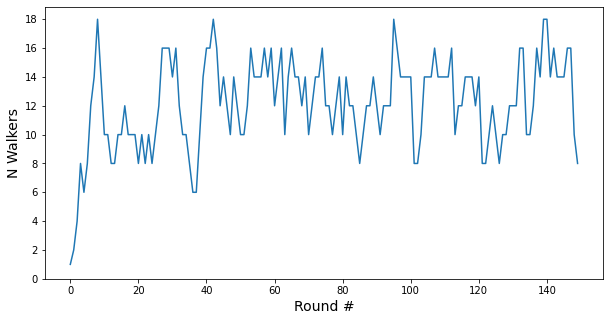

In [13]:
# plot total number of walkers (==parallel simulations) in each round
fig, axs = plt.subplots(figsize=(10,5))

n_walkers_per_round = [len(step_h) for step_h in we_sampler.history]

axs.plot(n_walkers_per_round)
axs.set_yticks(range(0, max(n_walkers_per_round) + 1, 2))
axs.set_ylabel("N Walkers", size=14)
axs.set_xlabel("Round #", size=14)

### Number of walkers per bin in each round

In [14]:
# get the number of walkers (==parallel simulations) for each bin separately
# make a history array
trajs_by_bin_start = np.zeros((len(we_sampler.history), we_sampler.n_bins))  # in which bin is the first frame of the traj
trajs_by_bin_end = np.zeros((len(we_sampler.history), we_sampler.n_bins))  # in which bin is the last frame of the traj

# and fill it
for step_num, step_history in enumerate(we_sampler.history):
    for result in step_history:
        # get all bin idxs the traj has visited
        bin_idxs = await we_sampler.get_bin_idxs_for_traj(result["traj"])
        # use the first frame (as it was the bin we started in)
        trajs_by_bin_start[step_num, bin_idxs[0]] += 1
        # use the last frame (as the bin we ended in)
        trajs_by_bin_end[step_num, bin_idxs[-1]] += 1

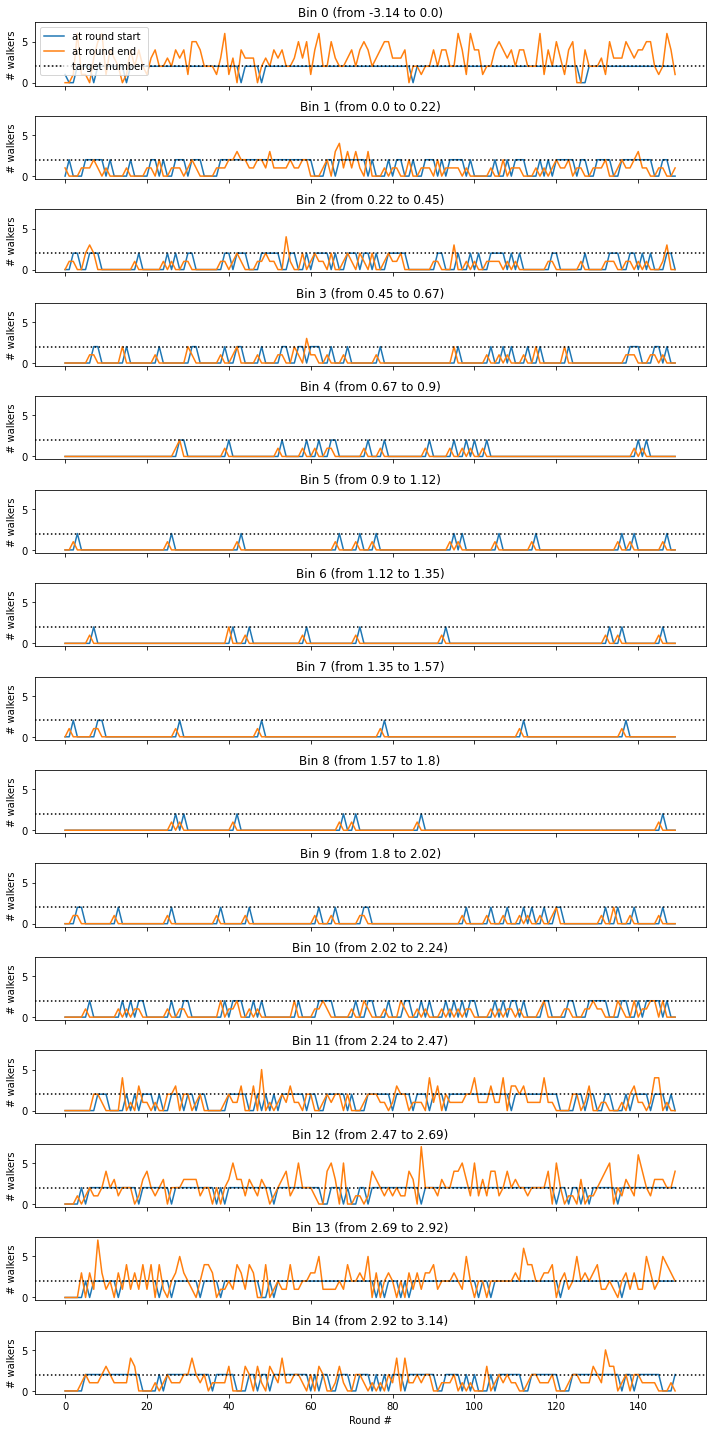

In [15]:
# plot it 
fig, axs = plt.subplots(we_sampler.n_bins, sharex=True, figsize=(10, 20), sharey=True)

for bin_idx in range(we_sampler.n_bins):
    ax = axs[bin_idx]
    n_walker_per_bin_start = trajs_by_bin_start[:, bin_idx]
    n_walker_per_bin_end = trajs_by_bin_end[:, bin_idx]
    ax.plot(n_walker_per_bin_start, label="at round start")
    ax.plot(n_walker_per_bin_end, label="at round end")
    ax.axhline(we_sampler.n_traj_target, ls=":", color="k", label="target number")
    if bin_idx == 0:
        # plot the legend
        ax.legend()
    ax.set_ylabel("# walkers")
    ax.set_title(f"Bin {bin_idx} (from {round(we_sampler.bin_edges[bin_idx], 2)} to {round(we_sampler.bin_edges[bin_idx + 1], 2)})")
ax.set_xlabel("Round #")

fig.tight_layout()

### Probability density and free energy in $\phi$/$\psi$-plane

In [16]:
# collect all trajs psi and phi values
all_traj_psi_phi = []
# and all weights
all_weights = []

for step_num, step_history in enumerate(we_sampler.history):
    for result in step_history:
        all_traj_psi_phi += [await wrapped_psi_phi(result["traj"])]
        all_weights += [np.full((all_traj_psi_phi[-1].shape[0],), result["weight"])]

all_weights_arr = np.concatenate(all_weights, axis=0)
all_traj_psi_phi_arr = np.concatenate(all_traj_psi_phi, axis=0)

/tmp/ipykernel_5173/258500750.py:17: RuntimeWarning: divide by zero encountered in log
  image = ax.imshow(-np.log(h.T), origin="lower", extent=[-np.pi, np.pi, -np.pi, np.pi], vmax=8, interpolation="none")


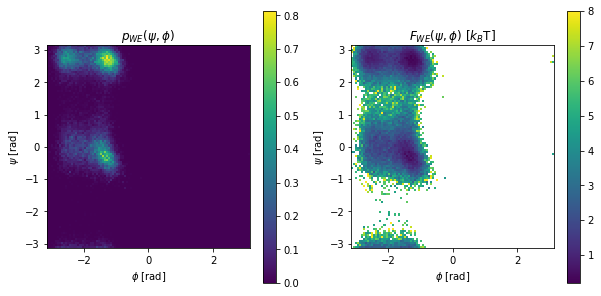

In [17]:
# plot histogram of psi/phi values with correct trajectory weights
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

h, xedges, yedges = np.histogram2d(x=all_traj_psi_phi_arr[:, 1],
                                   y=all_traj_psi_phi_arr[:, 0],
                                   weights=all_weights_arr,
                                   bins=100,
                                   range=[[-np.pi, np.pi], [-np.pi, np.pi]],
                                   density=True,
                                   )

for i, ax in enumerate(axs):
    if i == 0:
        image = ax.imshow(h.T, origin="lower", extent=[-np.pi, np.pi, -np.pi, np.pi], interpolation="none")
        ax.set_title("$p_{WE}(\psi, \phi)$")
    elif i == 1:
        image = ax.imshow(-np.log(h.T), origin="lower", extent=[-np.pi, np.pi, -np.pi, np.pi], vmax=8, interpolation="none")
        ax.set_title("$F_{WE}(\psi, \phi)$ [$k_B$T]")
    ax.set_ylabel("$\psi$ [rad]")
    ax.set_xlabel("$\phi$ [rad]")
    ax.set_aspect("equal")
    fig.colorbar(image, ax=ax)

### Number of consecutive trajectory parts per walker before it gets pruned

In [18]:
# get statistics on how many rounds each WE_walker did
n_parts_by_walker = {}
for walker_id, walker in we_sampler.walkers.items():
    n_parts_by_walker[walker_id] = len(walker.trajectories)

# make a list for plotting
n_parts_list = [n_parts for n_parts in n_parts_by_walker.values()]

Text(0, 0.5, 'Number of walkers')

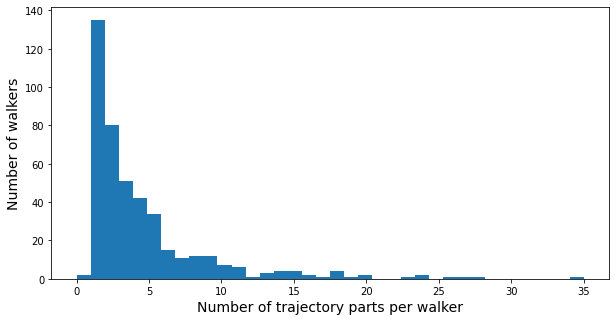

In [19]:
fig, axs = plt.subplots(figsize=(10,5))

axs.hist(n_parts_list, bins=max(n_parts_list) + 1)
axs.set_xlabel("Number of trajectory parts per walker", size=14)
axs.set_ylabel("Number of walkers", size=14)

## Compare weighted ensemble to an equilibrium simulation with the same number of integration steps as all the walkers combined
This is mostly to see if the weighted ensemble simulation was/is more efficient than a brute force integration in terms of integration steps.

While we also check and compare the total walltime each of the simulations run in this notebook, these numbers have to be interpreted with care: By running on a single workstation the weighted ensemble simulations are competing for the same resources and will probably run longer than if we run a single simulation with the same number of steps. However, due to the fact that the weighted ensemble simulation is trivially parallelizeable over multiple nodes of a supercomputer, the weighted ensemble will most likely finish in a (much) shorter walltime than the equilibrium simulation for all production settings.

### Create and prepare equilibrium engine

In [20]:
eq_engine = asyncgmx.GmxEngine(**engine_kwargs)
# get number of steps we did in total in all walkers combined
n_steps_eq = n_steps_per_round * np.sum([len(step_h) for step_h in we_sampler.history])
print(f"all walkers did {n_steps_eq} combined integration steps")

# prepare the engine
dirname = os.path.join(working_directory, "long_eq_sim")
os.mkdir(dirname)
# use the same starting configuration as for the WE
await eq_engine.prepare(starting_configuration=starting_configuration, workdir=dirname, deffnm="long_eq")

all walkers did 3654000 combined integration steps


### Run equilibrium engine

In [21]:
t_start = time.time() 
long_eq_traj = await eq_engine.run_steps(nsteps=n_steps_eq, steps_per_part=True)
t_end = time.time()
print(f"running long equilibrium trajectory took {round((t_end-t_start)/60, 2)} minutes.")

running long equilibrium trajectory took 13.09 minutes.


### Calculate CV values for equilibrium trajectory
This should be included in the total walltime for the equilibrium simulation as the weighted ensemble calculates these during the simulation to perform split and prune operations.

In [22]:
t_start = time.time() 
long_eq_traj_psi_phi = await wrapped_psi_phi(long_eq_traj)
t_end = time.time()
print(f"calculating psi, phi for long equilibrium trajectory took {round((t_end-t_start)/60, 2)} minutes.")

calculating psi, phi for long equilibrium trajectory took 0.34 minutes.


### Probability density and free energy in $\phi$/$\psi$-plane from equilibrium simulation

/tmp/ipykernel_5173/2928486900.py:15: RuntimeWarning: divide by zero encountered in log
  image = ax.imshow(-np.log(h_eq.T), origin="lower", extent=[-np.pi, np.pi, -np.pi, np.pi], vmax=8, interpolation="none")


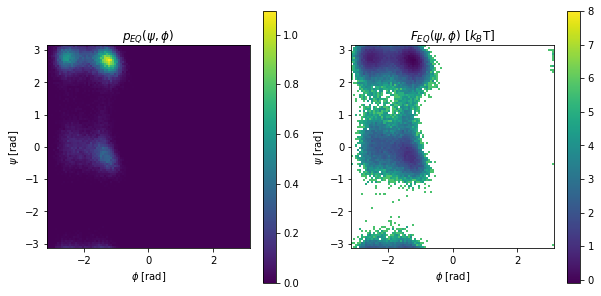

In [23]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

h_eq, xedges, yedges = np.histogram2d(x=long_eq_traj_psi_phi[:, 1],
                                   y=long_eq_traj_psi_phi[:, 0],
                                   bins=100,
                                   range=[[-np.pi, np.pi], [-np.pi, np.pi]],
                                   density=True,
                                   )

for i, ax in enumerate(axs):
    if i == 0:
        image = ax.imshow(h_eq.T, origin="lower", extent=[-np.pi, np.pi, -np.pi, np.pi], interpolation="none")
        ax.set_title("$p_{EQ}(\psi, \phi)$")
    elif i == 1:
        image = ax.imshow(-np.log(h_eq.T), origin="lower", extent=[-np.pi, np.pi, -np.pi, np.pi], vmax=8, interpolation="none")
        ax.set_title("$F_{EQ}(\psi, \phi)$ [$k_B$T]")
    ax.set_ylabel("$\psi$ [rad]")
    ax.set_xlabel("$\phi$ [rad]")
    ax.set_aspect("equal")
    fig.colorbar(image, ax=ax)

### Compare probability density and free energy in $\phi$/$\psi$-plane between equilibrium simulation and weighted ensemble

/tmp/ipykernel_5173/363822582.py:3: RuntimeWarning: divide by zero encountered in log
  F_eq = -np.log(h_eq.T)
/tmp/ipykernel_5173/363822582.py:4: RuntimeWarning: divide by zero encountered in log
  F_we = -np.log(h.T)
/tmp/ipykernel_5173/363822582.py:14: RuntimeWarning: invalid value encountered in subtract
  DF = F_eq - F_we


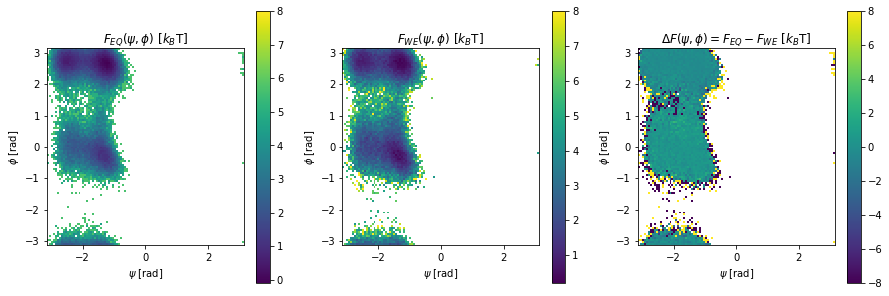

In [24]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

F_eq = -np.log(h_eq.T)
F_we = -np.log(h.T)

for i, ax in enumerate(axs):
    if i == 0:
        image = ax.imshow(F_eq, origin="lower", extent=[-np.pi, np.pi, -np.pi, np.pi], vmax=8, interpolation="none")
        ax.set_title("$F_{EQ}(\psi, \phi)$ [$k_B$T]")
    elif i == 1:
        image = ax.imshow(F_we, origin="lower", extent=[-np.pi, np.pi, -np.pi, np.pi], vmax=8, interpolation="none")
        ax.set_title("$F_{WE}(\psi, \phi)$ [$k_B$T]")
    elif i == 2:
        DF = F_eq - F_we
        DF[np.isinf(F_eq) & np.isinf(F_we)] = np.inf
        DF[np.isinf(F_eq) & np.isfinite(F_we)] = -8
        DF[np.isfinite(F_eq) & np.isinf(F_we)] = 8
        image = ax.imshow(DF, origin="lower", extent=[-np.pi, np.pi, -np.pi, np.pi], interpolation="none")
        ax.set_title("$\Delta F(\psi, \phi)=F_{EQ} - F_{WE}$ [$k_B$T]")
    ax.set_xlabel("$\psi$ [rad]")
    ax.set_ylabel("$\phi$ [rad]")
    ax.set_aspect("equal")
    fig.colorbar(image, ax=ax)